In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division, print_function
import os
import numpy as np
import pandas as pd
import pyunfold
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

import comptools as comp

sns.set_context(context='paper', font_scale=1.5)
color_dict = comp.color_dict

%matplotlib inline

In [3]:
config = 'IC86.2012'
num_groups = 2

comp_list = comp.get_comp_list(num_groups=num_groups)
energybins = comp.get_energybins(config)
num_ebins = len(energybins.log_energy_midpoints)

unfolding_dir  = os.path.join(comp.paths.comp_data_dir,
                              config,
                              'unfolding')

In [4]:
# Load DataFrame with saved prior distributions
df_file = os.path.join(unfolding_dir,
                       'unfolding-df_{}-groups.hdf'.format(num_groups))
df_priors = pd.read_hdf(df_file)
df_priors.head()

,counts,counts_err,efficiencies,efficiencies_err,broken_power_law_flux,broken_power_law_prior,simple_power_law_flux,simple_power_law_prior,H3a_flux,H3a_prior,H4a_flux,H4a_prior
log_energy_bin_idx,,,,,,,,,,,,
0,1071404.0,1035.086470,0.007119,0.000084,1.416780e-12,0.231674,1.416780e-12,0.231486,7.187420e-13,0.302586,7.333020e-13,0.306455
1,743932.0,862.514927,0.006400,0.000078,1.416780e-12,0.231674,1.416780e-12,0.231486,4.082709e-13,0.171880,4.023280e-13,0.168137
2,851277.0,922.646736,0.007928,0.000075,7.608561e-13,0.124416,7.608561e-13,0.124315,3.743101e-13,0.157582,3.821589e-13,0.159708
3,702982.0,838.440219,0.007473,0.000068,7.608561e-13,0.124416,7.608561e-13,0.124315,2.232925e-13,0.094005,2.198728e-13,0.091887
4,579872.0,761.493270,0.008373,0.000068,4.086039e-13,0.066816,4.086039e-13,0.066761,1.925426e-13,0.081059,1.967681e-13,0.082231


In [23]:
# Load simulation and train composition classifier
df_sim_train, df_sim_test = comp.load_sim(config=config,
#                                           energy_reco=True,
                                          energy_reco=False,
                                          log_energy_min=None,
                                          log_energy_max=None,
                                          test_size=0.5,
                                          n_jobs=10,
                                          verbose=True)

[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.2s


In [24]:
feature_list, feature_labels = comp.get_training_features()

In [25]:
print('Running energy reconstruction...')
energy_pipeline = comp.load_trained_model('linearregression_energy_{}'.format(config))
# energy_pipeline = comp.load_trained_model('RF_energy_{}'.format(config))
for df in [df_sim_train, df_sim_test]:
    X = df_sim_train[feature_list].values
    # Energy reconstruction
    df['reco_log_energy'] = energy_pipeline.predict(df[feature_list].values)
    df['reco_energy'] = 10**df['reco_log_energy']

Running energy reconstruction...


In [26]:
# Load fitted efficiencies and calculate effective areas
eff_path = os.path.join(comp.paths.comp_data_dir, config, 'efficiencies',
                        'efficiency_fit_num_groups_{}.hdf'.format(num_groups))
df_eff = pd.read_hdf(eff_path)
df_eff.head()

,eff_median_light,eff_err_low_light,eff_err_high_light,eff_median_heavy,eff_err_low_heavy,eff_err_high_heavy,eff_median_total,eff_err_low_total,eff_err_high_total
0,0.007119,0.000084,0.000077,0.006400,0.000078,0.000083,0.006739,0.000057,0.000053
1,0.007928,0.000075,0.000062,0.007473,0.000068,0.000072,0.007685,0.000044,0.000047
2,0.008373,0.000068,0.000063,0.008005,0.000064,0.000069,0.008194,0.000043,0.000046
3,0.008609,0.000070,0.000066,0.008268,0.000065,0.000067,0.008458,0.000046,0.000046
4,0.008735,0.000072,0.000068,0.008421,0.000063,0.000067,0.008606,0.000048,0.000045


In [27]:
# Get simulation thrown areas for each energy bin
thrown_radii = comp.simfunctions.get_sim_thrown_radius(energybins.log_energy_midpoints)
thrown_area = np.pi * thrown_radii.max()**2
thrown_area

9079202.768874502

In [28]:
efficiencies, efficiencies_err = comp.get_detector_efficiencies(config=config,
                                                                num_groups=num_groups,
                                                                sigmoid='slant',
                                                                pyunfold_format=True)

In [29]:
print('Running composition classifications...')
# pipeline_str = 'SGD_comp_{}_{}-groups'.format(config, num_groups)
pipeline_str = 'xgboost_comp_{}_{}-groups'.format(config, num_groups)
comp_pipeline = comp.load_trained_model(pipeline_str)
pred_target = comp_pipeline.predict(df_sim_test[feature_list].values)

Running composition classifications...


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [31]:
print('Making response matrix...')
log_reco_energy_sim_test = df_sim_test['reco_log_energy']
log_true_energy_sim_test = df_sim_test['MC_log_energy']
true_target = df_sim_test['comp_target_{}'.format(num_groups)].values

response, response_err = comp.response_matrix(true_energy=log_true_energy_sim_test,
                                              reco_energy=log_reco_energy_sim_test,
                                              true_target=true_target,
                                              pred_target=pred_target,
                                              efficiencies=efficiencies,
                                              efficiencies_err=efficiencies_err,
                                              energy_bins=energybins.log_energy_bins)

Making response matrix...


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


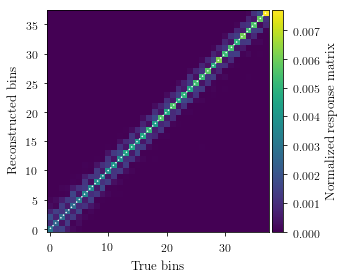

In [32]:
fig, ax = plt.subplots()
im = ax.imshow(response, origin='lower', cmap='viridis')
ax.plot([0, response.shape[0] - 1], [0, response.shape[1] - 1], marker='None', ls=':', color='white')
comp.plotting.colorbar(im, label='Normalized response matrix')

ax.set_xlabel('True bins')
ax.set_ylabel('Reconstructed bins')

plt.show()

In [45]:
print('Loading data into memory...')

# df_data = comp.load_data(config=config,
#                          processed=True,
#                          columns=feature_list + ['lap_ra', 'lap_dec'],
#                          n_jobs=15,
#                          verbose=True)

data_dir = os.path.join(comp.paths.comp_data_dir,
                        'IC86.2012',
                        'data')
filepath_up_shift = os.path.join(data_dir, 
                                'data_dataframe_vem_cal_up.hdf')
df_data = pd.read_hdf(filepath_up_shift,
                      columns=feature_list)

Loading data into memory...


In [48]:
X_data = df_data[feature_list].values

In [49]:
print('Running composition classifications...')
df_data['pred_comp_target'] = comp_pipeline.predict(X_data)

Running composition classifications...


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [50]:
print('Running energy regressions...')
df_data['reco_log_energy'] = energy_pipeline.predict(X_data)

Running energy regressions...


In [51]:
counts_observed = {}
counts_observed_err = {}

for comp_idx, composition in enumerate(comp_list):
    print(composition)
    # Filter out events that don't pass composition & energy mask
    pred_comp_mask = df_data['pred_comp_target'] == comp_idx
    mask = pred_comp_mask
    
    energies = df_data.loc[mask, 'reco_log_energy'].values
    comp_counts, _ = np.histogram(energies, bins=energybins.log_energy_bins)
    counts_observed[composition] = comp_counts
    counts_observed_err[composition] = np.sqrt(comp_counts)

counts_observed_err['total'] = np.sqrt(np.sum(counts_observed_err[composition]**2 for composition in comp_list))
# Calculate total counts
counts_observed['total'] = np.sum(counts_observed[composition] for composition in comp_list)

# Format observed counts, detection efficiencies, and priors for PyUnfold use
counts_pyunfold = np.empty(num_groups * len(energybins.energy_midpoints))
counts_err_pyunfold = np.empty(num_groups * len(energybins.energy_midpoints))
for idx, composition in enumerate(comp_list):
    counts_pyunfold[idx::num_groups] = counts_observed[composition]
    counts_err_pyunfold[idx::num_groups] = counts_observed_err[composition]

light
heavy


In [52]:
counts_observed

{'heavy': array([858610, 719102, 511265, 358013, 239299, 148300, 102542,  56066,
         38163,  26563,  14656,   9703,   6496,   4322,   2922,   1987,
          1337,    778,    596]),
 'light': array([1253781,  913514,  661325,  451780,  298671,  200302,  116987,
          79336,   44191,   23034,   15666,    8951,    5269,    3153,
           1908,    1072,     609,     428,     245]),
 'total': array([2112391, 1632616, 1172590,  809793,  537970,  348602,  219529,
         135402,   82354,   49597,   30322,   18654,   11765,    7475,
           4830,    3059,    1946,    1206,     841])}

In [53]:
# Effective area
eff_area, eff_area_err = {}, {}
for composition in comp_list + ['total']:
    eff_area[composition] = df_eff['eff_median_{}'.format(composition)].values * thrown_area
    eff_area_err[composition] = df_eff['eff_err_low_{}'.format(composition)].values * thrown_area

# Solid angle
theta_max = 40 if config == 'IC79.2010' else 65
solid_angle = np.pi*np.sin(np.deg2rad(theta_max))**2

# Livetime
livetime, livetime_err = comp.get_detector_livetime(config=config)

In [54]:
def counts_to_flux(counts, counts_err=None, composition=None):
    return comp.get_flux(counts, counts_err,
                         energybins=energybins.energy_bins,
                         eff_area=thrown_area, 
                         livetime=livetime,
                         livetime_err=livetime_err,
                         solid_angle=solid_angle,
                         scalingindex=2.7)

In [55]:
# Run unfolding for each of the priors
names = ['uniform', 'H3a', 'H4a', 'simple_power_law']
# names = ['Jeffreys', 'H3a', 'H4a', 'Polygonato']
unfolding_results = {}
for prior_name in names:
    prior = None if prior_name == 'uniform' else df_priors['{}_prior'.format(prior_name)]
    # priors = 'Jeffreys' if prior_name == 'Jeffreys' else df['{}_prior'.format(prior_name)]
    df_unfolding_iter = pyunfold.iterative_unfold(data=counts_pyunfold,
                                                  data_err=counts_err_pyunfold,
                                                  response=response,
                                                  response_err=response_err,
                                                  efficiencies=efficiencies,
                                                  efficiencies_err=efficiencies_err,
                                                  ts='ks',
                                                  ts_stopping=0.005,
                                                  prior=prior,
                                                  return_iterations=True)
#                                                   callbacks=[pyunfold.callbacks.SplineRegularizer(degree=1, smooth=256)])
    unfolding_results[prior_name] = df_unfolding_iter

In [56]:
names

['uniform', 'H3a', 'H4a', 'simple_power_law']

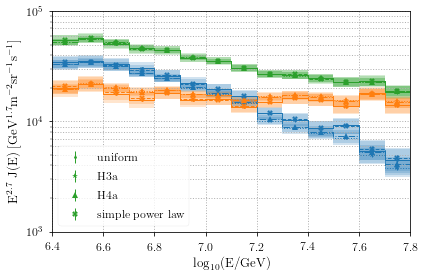

In [57]:
fig, ax = plt.subplots()
# fig, ax = plt.subplots(figsize=(10, 5))
linestyles = ['-', ':', '-.', '--']
markers = ['.', '*', '^', 'X']
for prior_name, ls, marker in zip(names, linestyles, markers):
#     if prior_name != 'H4a':
#         continue
    counts, counts_sys_err, counts_stat_err = comp.unfolded_counts_dist(unfolding_results[prior_name],
                                                                        num_groups=num_groups)
    for composition in comp_list + ['total']:
#         print(composition)
#         print(counts[composition])
        flux, flux_sys_err = counts_to_flux(counts=counts[composition],
                                            counts_err=counts_sys_err[composition],
                                            composition=composition)
        flux, flux_stat_err = counts_to_flux(counts=counts[composition],
                                             counts_err=counts_stat_err[composition],
                                             composition=composition)
        comp.plot_steps(energybins.log_energy_bins, flux,
                        yerr=flux_sys_err,
                        color=color_dict[composition],
                        ls=ls,
                        ax=ax)
#         label = '{} ({})'.format(composition, prior_name.replace('_', '-'))
        label = prior_name.replace('_', ' ') if composition == 'total' else ''
        ax.errorbar(energybins.log_energy_midpoints, flux,
                    yerr=flux_stat_err,
                    color=color_dict[composition],
                    ls='None',
                    marker=marker,
                    capsize=20,
                    elinewidth=1,
                    label=label)
ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
ax.set_xlim(6.4, 7.8)
ax.set_ylim(1e3, 1e5)
ax.grid(lw=1, which='both')
ax.legend()
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend(loc='upper center',
#           bbox_to_anchor=(0.5, 1.75),
#           ncol=2,
#           fancybox=True)

outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'allsky.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

In [220]:
unfolding_results[prior_name]

,num_iterations,stat_err,sys_err,ts_iter,ts_stopping,unfolded
0,1,"[103070.02504396967, 102144.86379256786, 50670...","[15749287.516949983, 15916022.452854631, 63263...",0.092134,0.005,"[191757396.1416671, 185164877.99562967, 100489..."
1,2,"[131953.06978832203, 129540.18108453172, 63206...","[20462526.446218558, 20765857.73598618, 772244...",0.013259,0.005,"[194439030.48473287, 183098573.05224302, 97407..."
2,3,"[156768.8273093421, 154851.65411568832, 76436....","[24771671.80102233, 25258328.6961266, 9280394....",0.006603,0.005,"[199315688.28344995, 184217275.63812009, 95749..."
3,4,"[179558.32058617944, 178243.33187288075, 88589...","[28715669.559097447, 29414788.434875157, 10789...",0.006247,0.005,"[203645760.02327502, 185650774.9339217, 942914..."
4,5,"[200461.48714098573, 199795.5892395803, 99408....","[32313868.88569669, 33238876.805621095, 121820...",0.005381,0.005,"[207218369.0219479, 187062412.3038028, 9288674..."
5,6,"[219513.50583395315, 219594.3790580178, 108934...","[35591637.47533877, 36746004.07863727, 1344948...",0.004610,0.005,"[210131297.34194955, 188430133.6614856, 915163..."


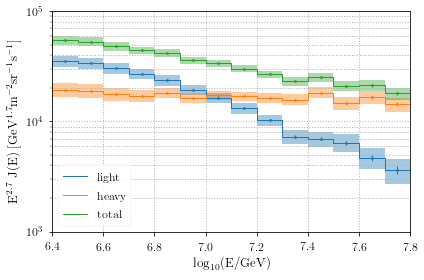

In [224]:
fig, ax = plt.subplots()
# fig, ax = plt.subplots(figsize=(10, 5))

prior_name = 'H4a'
marker = '.'
ls = '-'
counts, counts_sys_err, counts_stat_err = comp.unfolded_counts_dist(unfolding_results[prior_name],
                                                                    num_groups=num_groups)
for composition in comp_list + ['total']:
    flux, flux_sys_err = counts_to_flux(counts=counts[composition],
                                        counts_err=counts_sys_err[composition],
                                        composition=composition)
    flux, flux_stat_err = counts_to_flux(counts=counts[composition],
                                         counts_err=counts_stat_err[composition],
                                         composition=composition)
    comp.plot_steps(energybins.log_energy_bins, flux,
                    yerr=flux_sys_err,
                    color=color_dict[composition],
                    fillalpha=0.4,
                    ls=ls,
                    label=composition,
                    ax=ax)
    ax.errorbar(energybins.log_energy_midpoints, flux,
                yerr=flux_stat_err,
                color=color_dict[composition],
                ls='None',
                marker=marker,
                capsize=20,
                elinewidth=1)

ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
ax.set_xlim(6.4, 7.8)
ax.set_ylim(1e3, 1e5)
ax.grid(lw=1, which='both')

ax.legend()
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend(loc='upper center',
#           bbox_to_anchor=(0.5, 1.75),
#           ncol=2,
#           fancybox=True)

outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'allsky.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

The directory /home/jbourbeau/public_html/figures/composition/unfolding/IC86.2012/iterations/simple_power_law/2-groups doesn't exist. Creating it...


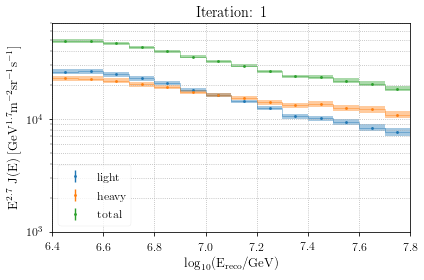

In [222]:
fig, ax = plt.subplots()

prior_name = 'simple_power_law'
marker = '.'
ls = '-'

df_unfolding = unfolding_results[prior_name]

def update(i):
    ax.clear()
    idx_iter, df_iter = i
    color_dict_iter = {}
    color_dict_iter['light'] = sns.color_palette('Blues', len(df_unfolding.index)).as_hex()[idx_iter]
    color_dict_iter['heavy'] = sns.color_palette('Oranges', len(df_unfolding.index)).as_hex()[idx_iter]
    color_dict_iter['total'] = sns.color_palette('Greens', len(df_unfolding.index)).as_hex()[idx_iter]
        
    counts, counts_sys_err, counts_stat_err = comp.unfolded_counts_dist(unfolding_results[prior_name],
                                                                        iteration=idx_iter,
                                                                        num_groups=num_groups)
        
    for idx, composition in enumerate(comp_list):
        if idx == 0:
            counts['total'] = np.zeros_like(counts[composition])
            counts_sys_err['total'] = np.zeros_like(counts[composition])
            counts_stat_err['total'] = np.zeros_like(counts[composition])
        counts['total'] += counts[composition]
        counts_sys_err['total'] += counts_sys_err[composition]**2
        counts_stat_err['total'] += counts_stat_err[composition]**2
    counts_sys_err['total'] = np.sqrt(counts_sys_err['total'])
    counts_stat_err['total'] = np.sqrt(counts_stat_err['total'])    
    
    for composition in comp_list + ['total']:    
        flux, flux_err_sys = comp.get_flux(counts[composition], counts_sys_err[composition],
                                                     energybins=energybins.energy_bins,
                                                     eff_area=thrown_area,
                                                     livetime=livetime, livetime_err=livetime_err, 
                                                     solid_angle=solid_angle)
        flux, flux_err_stat = comp.get_flux(counts[composition], counts_stat_err[composition],
                                                     energybins=energybins.energy_bins,
                                                     eff_area=thrown_area,
                                                     livetime=livetime, livetime_err=livetime_err, 
                                                     solid_angle=solid_angle)
        
        comp.plot_steps(energybins.log_energy_bins, flux, yerr=flux_err_sys,
                            ax=ax, alpha=0.4, fillalpha=0.4,  
                            color=color_dict[composition])
        ax.errorbar(energybins.log_energy_midpoints, flux, yerr=flux_err_stat,  
                    color=color_dict[composition], ls='None', marker='.', 
                    label=composition)
        

    ax.set_yscale("log", nonposy='clip')
    ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
    ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
    ax.set_title('Iteration: {}'.format(idx_iter+1))
    ax.set_xlim(6.4, 7.8)
    ax.set_ylim([1e3, 7e4])
    ax.grid(linestyle='dotted', which="both")
    ax.legend()
    
    return ax

anim = FuncAnimation(fig, update, frames=list(df_unfolding.iterrows()),
                     interval=1250)
iter_unfold_outfile = os.path.join(comp.paths.figures_dir,
                                   'unfolding',
                                   config,
                                   'iterations', 
                                   prior_name,
                                   '{}-groups'.format(num_groups),
                                   'flux_iter_{}-prior.gif'.format(prior_name))
comp.check_output_dir(iter_unfold_outfile)
anim.save(iter_unfold_outfile, dpi=300, writer='imagemagick')

## Cosmic-ray flux vs. sky position

In [20]:
import healpy as hp

In [24]:
nside = 64
npix = hp.nside2npix(nside)

In [52]:
m = np.zeros(npix)
m[hp.ang2pix(nside, np.pi/2, np.pi/2)] = 1
m[hp.ang2pix(nside, np.pi/4, np.pi/4)] = 1
# m[:100] = 100

In [71]:
df_data.iloc[:100][['lap_ra', 'lap_dec']].head()

,lap_ra,lap_dec
IC86.2012_120028_6075870_0,1.994832,-1.323424
IC86.2012_120028_6077647_0,2.368135,-1.081708
IC86.2012_120028_6088516_0,3.785567,-1.176766
IC86.2012_120028_6089628_0,3.411561,-1.167795
IC86.2012_120028_6094183_0,2.524475,-1.177557


In [291]:
ra = df_data.loc[:, 'lap_ra'].values
dec = df_data.loc[:, 'lap_dec'].values

Convert from ra/dec equatorial coordinates to the theta/phi coordinates used in `healpy`

In [291]:
theta, phi = comp.equatorial_to_healpy(ra, dec)

In [292]:
skymap = np.zeros(npix)
unique_pix, pix_counts = np.unique(pix_array, return_counts=True)
skymap[unique_pix] += pix_counts

In [273]:
def mask_map(skymap, decmin=None, decmax=None):

    if decmin is None and decmax is None:
        raise ValueError('decmin and/or decmax must be specified')

    npix  = skymap.shape[0]
    nside = hp.npix2nside(npix)
    theta, phi = hp.pix2ang(nside, range(npix))
    print(theta)

    theta_mask = np.ones(npix, dtype=bool)
    if decmin is not None:
        theta_min = np.deg2rad(90 - decmin)
        print(theta_min)
        theta_mask *= (theta >= theta_min)
        print(theta_mask.sum())
    if decmax is not None:
        theta_max = np.deg2rad(90 - decmax)
        print(theta_max)
        theta_mask *= (theta <= theta_max)
        print(theta_mask.sum())

    masked_map = np.copy(skymap)
    masked_map[theta_mask] = hp.UNSEEN

    return masked_map

In [293]:
masked_m = mask_map(skymap, decmin=None, decmax=-40)
np.sum(masked_m == hp.UNSEEN)

[0.01275785 0.01275785 0.01275785 ... 3.12883481 3.12883481 3.12883481]
2.2689280275926285
40320


40320

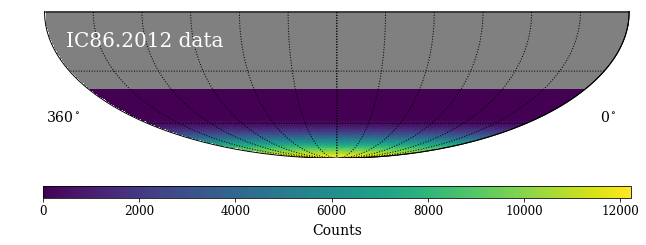

In [294]:
from matplotlib.ticker import FormatStrFormatter

hp.mollview(masked_m, rot=180, title='', cbar=False)
hp.graticule(verbose=False)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image,
                    orientation='horizontal',
                    aspect=50,
                    pad=0.01,
                    fraction=0.1,
                    ax=ax,
                    format=FormatStrFormatter('%g'),
                    shrink=1.0)
cbar.set_label('Counts', size=14)
ax.set_ylim(-1, 0.005)
ax.annotate('0$^\circ$', xy=(1.8, -0.75), size=14)
ax.annotate('360$^\circ$', xy=(-1.99, -0.75), size=14)
ax.annotate('IC86.2012 data', xy=(-1.85,-0.24), size=20, color='white')
plt.show()

In [296]:
theta, phi

(array([2.8942202 , 2.65250396, 2.74756195, ..., 2.91053932, 2.85528816,
        2.80141079]),
 array([1.99483155, 2.36813548, 3.78556748, ..., 2.45471226, 4.24586246,
        3.26226786]))

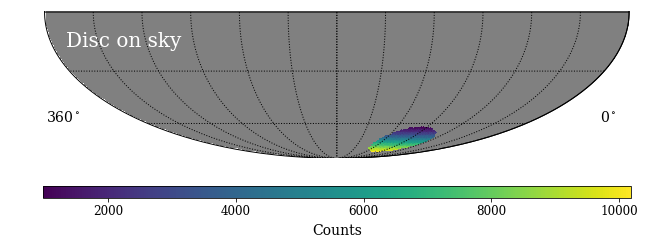

In [300]:
test_m = np.zeros(npix)
radius = np.deg2rad(10)
event_id = 10
vec = hp.ang2vec(theta[event_id], phi[event_id])
ipix = hp.query_disc(nside, vec=vec, radius=radius)
in_disc = np.isin(np.arange(npix), ipix)
test_m[in_disc] = 2
test_m[~in_disc] = 1

data_disc = skymap.copy()
data_disc[~in_disc] = hp.UNSEEN

hp.mollview(data_disc, rot=180, title='', cbar=False)
hp.graticule(verbose=False)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image,
                    orientation='horizontal',
                    aspect=50,
                    pad=0.01,
                    fraction=0.1,
                    ax=ax,
                    format=FormatStrFormatter('%g'),
                    shrink=1.0)
cbar.set_label('Counts', size=14)
ax.set_ylim(-1, 0.005)
ax.annotate('0$^\circ$', xy=(1.8, -0.75), size=14)
ax.annotate('360$^\circ$', xy=(-1.99, -0.75), size=14)
ax.annotate('Disc on sky', xy=(-1.85,-0.24), size=20, color='white')
plt.show()

In [302]:
dec.min(), dec.max()

(-1.5706758358557722, -0.9144460118811598)

dec_median = -1.31664469968 [rad]
dec_median = -75.4381844099 [deg]


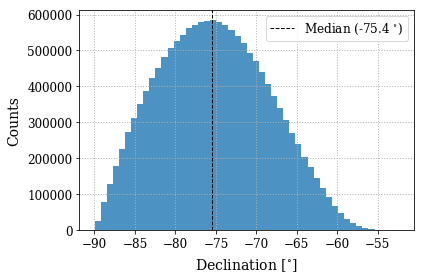

In [349]:
fig, ax = plt.subplots()
ax.hist(np.rad2deg(dec), bins=50, alpha=0.8)
dec_median = np.median(dec)
dec_median_deg = np.rad2deg(dec_median)
print('dec_median = {} [rad]'.format(dec_median))
print('dec_median = {} [deg]'.format(dec_median_deg))
ax.axvline(dec_median_deg, marker='None', ls='--', lw=1, color='k',
           label='Median ({:0.1f}'.format(dec_median_deg)+' $^{\circ}$)')
# ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('Declination [$^{\circ}$]')
ax.set_ylabel('Counts')
ax.grid()
ax.legend()
plt.show()

In [346]:
dec_mask = df_data.lap_dec < dec_median
df_data df_data.loc[dec_mask]

IC86.2012_120028_6075870_0   -1.323424
IC86.2012_120028_6095290_0   -1.481215
IC86.2012_120028_6106962_0   -1.420575
IC86.2012_120028_6122859_0   -1.541910
IC86.2012_120028_6150683_0   -1.347749
IC86.2012_120028_6160121_0   -1.409074
IC86.2012_120028_6177951_0   -1.437435
IC86.2012_120028_6182558_0   -1.470857
IC86.2012_120028_6200240_0   -1.404683
IC86.2012_120028_6219569_0   -1.328515
IC86.2012_120028_6228667_0   -1.429264
IC86.2012_120028_6236308_0   -1.348106
IC86.2012_120028_6251525_0   -1.335412
IC86.2012_120028_6257336_0   -1.390313
IC86.2012_120028_6261707_0   -1.450918
IC86.2012_120028_6265022_0   -1.450372
IC86.2012_120028_6285789_0   -1.396544
IC86.2012_120028_6307544_0   -1.392730
IC86.2012_120028_6318673_0   -1.324990
IC86.2012_120028_6319546_0   -1.343454
IC86.2012_120028_6338590_0   -1.339980
IC86.2012_120028_6351626_0   -1.384467
IC86.2012_120028_6411945_0   -1.319622
IC86.2012_120028_6422892_0   -1.328417
IC86.2012_120028_6425917_0   -1.317800
IC86.2012_120028_6446535_

In [348]:
df_data.loc[df_data.lap_dec > dec_median, 'lap_dec']

IC86.2012_120028_6077647_0   -1.081708
IC86.2012_120028_6088516_0   -1.176766
IC86.2012_120028_6089628_0   -1.167795
IC86.2012_120028_6094183_0   -1.177557
IC86.2012_120028_6094399_0   -1.271440
IC86.2012_120028_6094537_0   -1.234041
IC86.2012_120028_6098852_0   -1.253068
IC86.2012_120028_6101501_0   -1.227375
IC86.2012_120028_6104847_0   -1.262051
IC86.2012_120028_6105170_1   -1.085234
IC86.2012_120028_6116044_0   -1.296417
IC86.2012_120028_6143069_0   -1.224308
IC86.2012_120028_6143665_0   -1.308779
IC86.2012_120028_6155001_0   -1.232278
IC86.2012_120028_6156929_0   -1.313176
IC86.2012_120028_6161194_0   -1.303295
IC86.2012_120028_6172565_0   -1.085976
IC86.2012_120028_6192282_0   -1.248428
IC86.2012_120028_6197563_0   -1.207689
IC86.2012_120028_6201094_0   -1.228728
IC86.2012_120028_6207773_0   -1.206896
IC86.2012_120028_6223615_0   -1.103649
IC86.2012_120028_6224678_0   -1.221837
IC86.2012_120028_6235221_0   -1.233793
IC86.2012_120028_6276862_0   -1.153754
IC86.2012_120028_6285257_